The very first attampt to use QuantLib and BS model and generate a call price.
stock_price is stored in quote so we can change the value later.

In [27]:
import QuantLib as ql
import numpy as np

# option data
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(170.0)
strike_price = 150
volatility = 0.10 # the historical vols for a year
dividend_rate =  0.002
risk_free_rate = 0.003
option_type = ql.Option.Call

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(27, 10, 2019)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


Analytic Black-Scholes calculation:

In [28]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
delta = european_option.delta()
gamma = european_option.gamma()
vega = european_option.vega()
rho = european_option.rho()

print("The theoretical price is ", bs_price)
print("The delta is ", delta)
print("The gamma is ", gamma)
print("The vega is ", vega)
print("The rho is ", rho)

The theoretical price is  20.912114216635807
The delta is  0.9022541582733737
The gamma is  0.009938484700038275
The vega is  29.03698484648708
The rho is  133.9228306919182


In [6]:
#prepare for plotting
xs_bs = np.linspace(100, 200, 400)
ys_bs = []
for x in xs_bs:
    stock_price.setValue(x)
    ys_bs.append(european_option.NPV())

Instead of using analytic Black-Scholes formula, we can use Monte-Carlo simulation.

In [7]:
stock_price.setValue(170)
engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                      timeSteps=20,
                                      requiredSamples=250000)
european_option.setPricingEngine(engine)
bs_price = european_option.NPV()
error = european_option.errorEstimate()
print("The monte carlo theoretical price is ", bs_price)
print("The monte carlo error is ", error)

The monte carlo theoretical price is  20.92493667128933
The monte carlo error is  0.03171475958195919


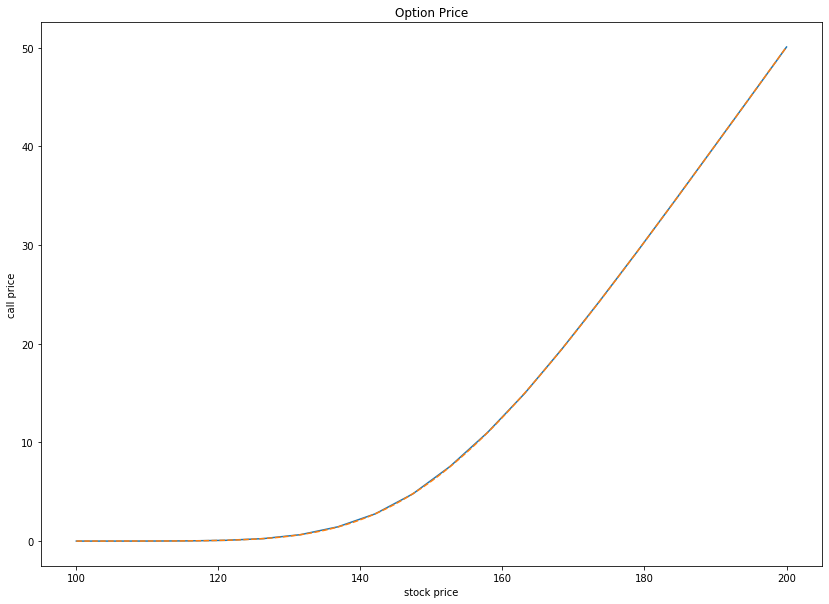

In [8]:
%matplotlib inline
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

xs = np.linspace(100, 200, 20)
ys = []
for x in xs:
    stock_price.setValue(x)
    ys.append(european_option.NPV())
    
plt.figure(figsize=(14,10))
plt.plot(xs, ys)
plt.plot(xs_bs, ys_bs, linestyle='dashed')
plt.xlabel('stock price') 
plt.ylabel('call price') 
plt.title('Option Price') 
plt.show() 


In [35]:
barrier, barrierType, optionType, rebate = (160.0, ql.Barrier.DownOut, ql.Option.Put, 0.0)
option = ql.BarrierOption(barrierType, barrier, rebate, 
                       payoff, 
                       ql.EuropeanExercise(maturity_date))
option.setPricingEngine(ql.AnalyticBarrierEngine(bsm_process))
trueValue = option.NPV()

print("The theoretical price is ", trueValue)


The theoretical price is  19.99514142398582


In [31]:
#basket options


from QuantLib import *
import matplotlib.pyplot as plt
stock_price = ql.SimpleQuote(150.0)
strike_price = 150
barrier, barrierType, optionType, rebate = (strike_price*1.1, Barrier.UpOut, Option.Put, 0.0)
underlying, strike, rf, sigma, maturity, divYield = (100, 105, 5e-2, 20e-2, 12, 0.0)
## maturity is in days and must be an integer 
barrier_data = dict( (name,eval(name)) for name in [
    'barrier', 'barrierType', 'optionType', 'rebate', 'underlying', 'strike', 
    'rf', 'sigma', 'maturity', 'divYield'] )
barrier_data['barrierType'] = ['DownIn', 'UpIn', 'DownOut', 'UpOut'][barrier_data['barrierType']]
barrier_data['optionType'] = ['Put', '???', 'Call'][barrier_data['optionType']+1]
for k in barrier_data.keys():
    print("{} = {}".format(k, barrier_data[k]))

today = Settings.instance().evaluationDate
maturity_date = today + int(maturity)
process = BlackScholesMertonProcess(
    QuoteHandle(SimpleQuote(underlying)),
    YieldTermStructureHandle(FlatForward(today, divYield, Thirty360())),
    YieldTermStructureHandle(FlatForward(today, rf, Thirty360())),
    BlackVolTermStructureHandle(BlackConstantVol(
        today, NullCalendar(), sigma, Thirty360())))
option = BarrierOption(barrierType, barrier, rebate, 
                       PlainVanillaPayoff(optionType, strike), 
                       EuropeanExercise(maturity_date))
option.setPricingEngine(AnalyticBarrierEngine(process))
trueValue = option.NPV()

print(trueValue)

barrier = 165.0
barrierType = UpOut
optionType = Put
rebate = 0.0
underlying = 100
strike = 105
rf = 0.05
sigma = 0.2
maturity = 12
divYield = 0.0
4.985491231912263


An Option Class which stores all the options info; return BS model call price; return the wanted data set for training purpose.

In [4]:
class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


Functions to help in converting and auto-generate specific numbers of options sample data for training.

In [5]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,10,30)
    end_maturity = datetime.datetime(2022,10,30)

    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0.001, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.BSM_price())
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


In [11]:
n = 300000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
#print(df)
print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = train['call_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = test['call_price'].values

stock_price       False
strike_price      False
maturity          False
devidends         False
volatility        False
risk_free_rate    False
call_price        False
dtype: bool


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
from tensorflow import squeeze

# problem is not because of my custom activation function, it's because of exponential activation not applied in this case

nodes = 100
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('exponential'))
          
model.compile(loss='mse',optimizer='rmsprop')

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Using TensorFlow backend.


Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 6s - loss: nan - val_loss: nan
Epoch 2/10
 - 5s - loss: nan - val_loss: nan
Epoch 3/10
 - 5s - loss: nan - val_loss: nan
Epoch 4/10
 - 5s - loss: nan - val_loss: nan
Epoch 5/10
 - 5s - loss: nan - val_loss: nan
Epoch 6/10
 - 5s - loss: nan - val_loss: nan
Epoch 7/10
 - 5s - loss: nan - val_loss: nan
Epoch 8/10
 - 5s - loss: nan - val_loss: nan
Epoch 9/10
 - 5s - loss: nan - val_loss: nan
Epoch 10/10
 - 5s - loss: nan - val_loss: nan
The mean squared error (MSE) for the test data set is: nan


A modified NN which gives really good results. Haven't adapted to their scaling method.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=6,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]

#no. of epochs as a hyperparameter

model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)

y_test_hat = model.predict(X_test)


Train on 192000 samples, validate on 48000 samples
Epoch 1/30
 - 5s - loss: 0.5215 - val_loss: 0.0055
Epoch 2/30
 - 4s - loss: 0.0360 - val_loss: 0.0847
Epoch 3/30
 - 5s - loss: 0.0210 - val_loss: 0.0103
Epoch 00003: early stopping
The mean squared error (MSE) for the test data set is: 0.010012359894751197


In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7434966614734429415
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9210949796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5980424637199658622
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Num GPUs Available:  1


['/job:localhost/replica:0/task:0/device:GPU:0']

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


n = 30000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
X = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
Y = df['call_price'].values
kf = KFold(10, shuffle=True)
cvscores = []
print("cross-validation started.")
for train, test in kf.split(X, Y):
    model = Sequential()
    model.add(Dense(50,input_dim=6,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'] )
    model.fit(X[train], Y[train], epochs=10, batch_size=10, verbose=0)
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))


cross-validation started.
accuracy: 1.13%
accuracy: 1.13%
accuracy: 1.30%
accuracy: 1.23%
accuracy: 1.63%
accuracy: 1.60%
accuracy: 1.67%
accuracy: 0.93%
accuracy: 1.07%
accuracy: 1.10%
1.28% (+/- 0.25%)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

model = Sequential()

nodes = 100
model.add(Dense(nodes,input_dim=6))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train, y_train, epochs=10, shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)
print(y_train_hat)

y_test_hat = model.predict(X_test)
print(y_test_hat)

Epoch 1/10
 - 9s - loss: 4.2128
Epoch 2/10
 - 8s - loss: 0.7495
Epoch 3/10
 - 8s - loss: 0.6419
Epoch 4/10
 - 8s - loss: 0.6306
Epoch 5/10
 - 8s - loss: 0.5909
Epoch 6/10
 - 8s - loss: 0.5717
Epoch 7/10
 - 8s - loss: 0.5533
Epoch 8/10
 - 9s - loss: 0.5617
Epoch 9/10
 - 9s - loss: 0.5645
Epoch 10/10
 - 9s - loss: 0.5484
The mean squared error (MSE) for the test data set is: 0.3346826271476617
[[0.21677184]
 [0.21677184]
 [0.21677184]
 ...
 [0.38034475]
 [0.21677184]
 [0.21677184]]
[[10.313256  ]
 [ 0.21677184]
 [ 0.51833975]
 ...
 [ 1.5997694 ]
 [10.955016  ]
 [ 0.21677184]]


Mean Squared Error:       0.4691783024075365
Root Mean Squared Error:  0.6849659133179815
Mean Absolute Error:      0.2360733901838385
Mean Percent Error:       0.47370593656043414


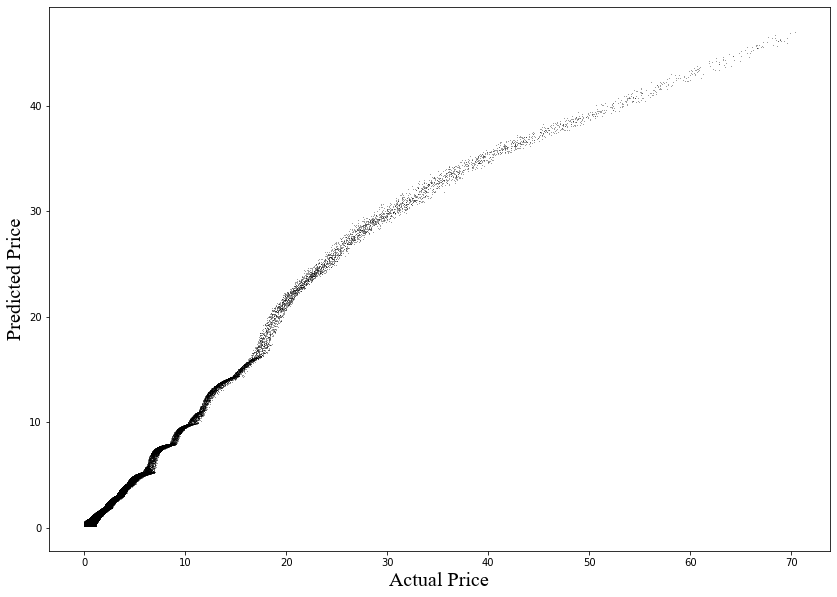

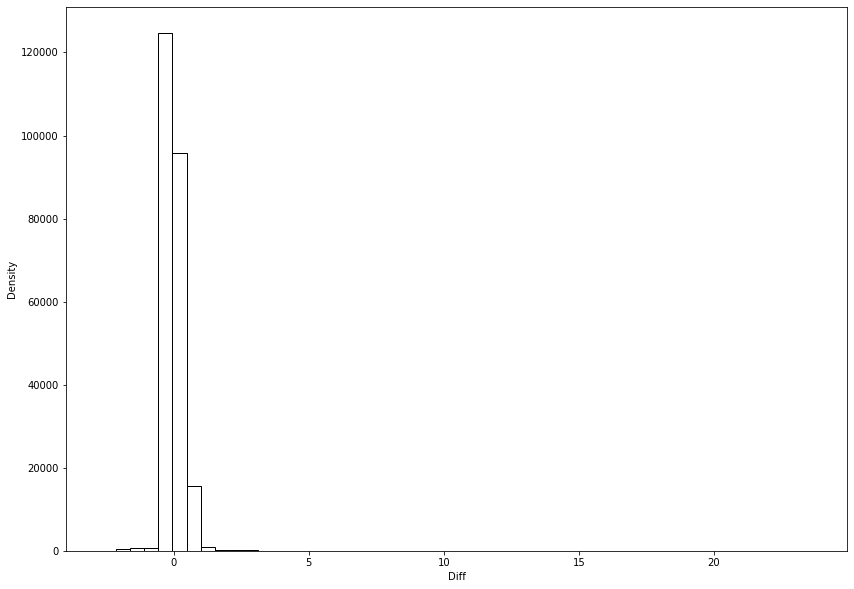

In [15]:
from statistics import *
from math import sqrt
import matplotlib as mpl
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = squeeze(y_train_hat).numpy()
CheckAccuracy(y_train, y_train_hat)

Mean Squared Error:       0.4385555521522155
Root Mean Squared Error:  0.6622352694867705
Mean Absolute Error:      0.23362485764642463
Mean Percent Error:       0.457161229523597


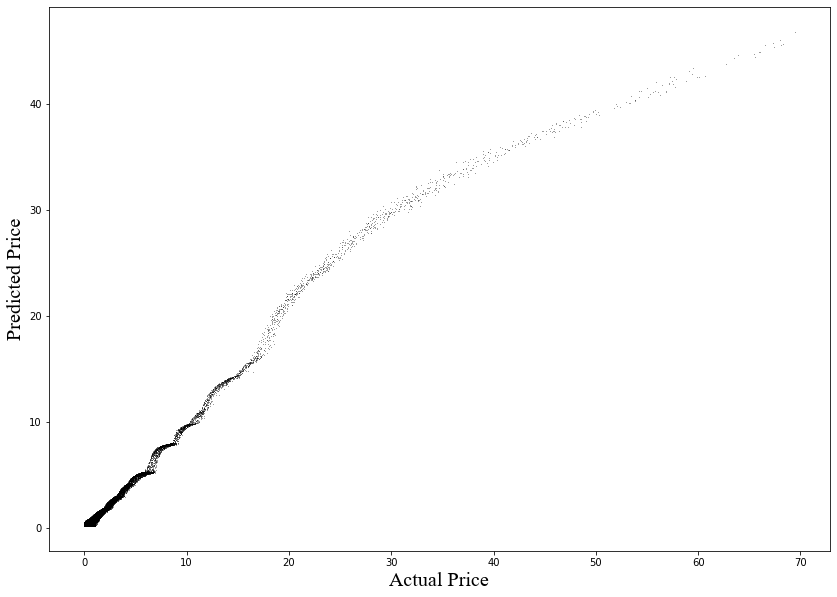

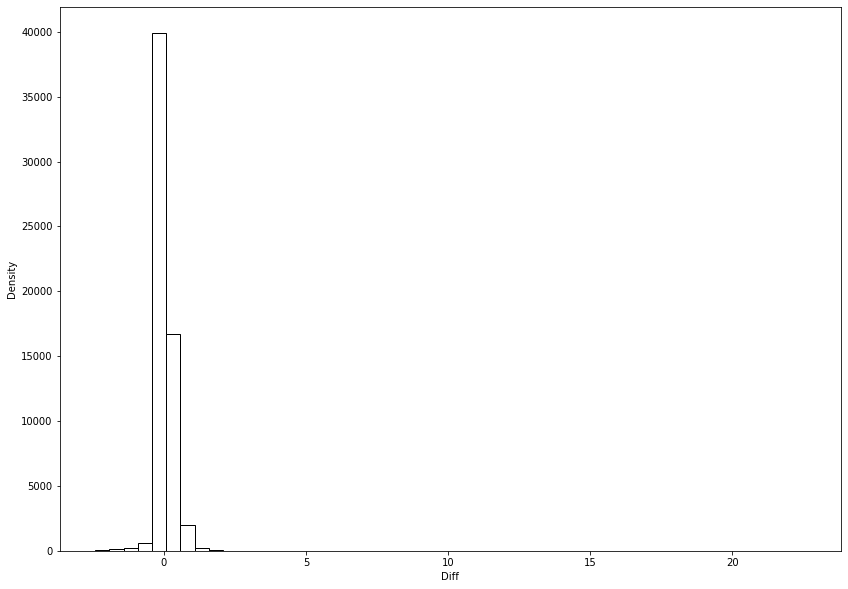

In [16]:
y_test_hat = squeeze(y_test_hat).numpy()
CheckAccuracy(y_test, y_test_hat)